In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path('.')
FIG_DIR = Path('./figures')
FIG_DIR.mkdir(exist_ok=True)


In [5]:
races = pd.read_csv(DATA_DIR/'races.csv')
results = pd.read_csv(DATA_DIR/'results.csv')
drivers = pd.read_csv(DATA_DIR/'drivers.csv')
constructors = pd.read_csv(DATA_DIR/'constructors.csv')

for name, df in {"races": races, "results": results, "drivers": drivers, "constructors": constructors}.items():
    print(name, df.shape)
    display(df.head(3))


races (1125, 18)


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


results (26759, 18)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1


drivers (861, 9)


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg


constructors (212, 5)


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...


In [7]:

Xy = (results
      .merge(races[['raceId','year','round','circuitId','name','date']], on='raceId', how='left')
      .merge(drivers[['driverId','driverRef','dob']], on='driverId', how='left')
      .merge(constructors[['constructorId','name']].rename(columns={'name':'constructor_name'}),
             on='constructorId', how='left'))


Xy['podium'] = (Xy['positionOrder'] <= 3).astype(int)


Xy = Xy.sort_values(['driverId','year','round','raceId']).reset_index(drop=True)


Xy['driver_starts_so_far'] = Xy.groupby('driverId').cumcount()

Xy['driver_podiums_so_far'] = (
    Xy.groupby('driverId')['podium']
      .shift(1)
      .fillna(0).astype(int)
      .groupby(Xy['driverId']).cumsum()
)

Xy['driver_podium_rate_so_far'] = np.where(
    Xy['driver_starts_so_far'] > 0,
    Xy['driver_podiums_so_far'] / Xy['driver_starts_so_far'],
    0.0
)

Xy['team_starts_so_far'] = Xy.groupby('constructorId').cumcount()

Xy['team_podiums_so_far'] = (
    Xy.groupby('constructorId')['podium']
      .shift(1)
      .fillna(0).astype(int)
      .groupby(Xy['constructorId']).cumsum()
)

Xy['team_podium_rate_so_far'] = np.where(
    Xy['team_starts_so_far'] > 0,
    Xy['team_podiums_so_far'] / Xy['team_starts_so_far'],
    0.0
)

features = [
    'grid', 'year',
    'driver_starts_so_far', 'driver_podium_rate_so_far',
    'team_starts_so_far',   'team_podium_rate_so_far'
]

model_df = Xy.dropna(subset=['positionOrder'])[features + ['podium','raceId','driverId','constructorId']].copy()
model_df.head()


,grid,year,driver_starts_so_far,driver_podium_rate_so_far,team_starts_so_far,team_podium_rate_so_far,podium,raceId,driverId,constructorId
0,4,2007,0,0.0,0,0.0,1,36,1,1
1,4,2007,1,1.0,1,1.0,1,37,1,1
2,2,2007,2,1.0,2,1.0,1,38,1,1
3,4,2007,3,1.0,3,1.0,1,39,1,1
4,2,2007,4,1.0,4,1.0,1,40,1,1


from matplotlib import pyplot as plt
_df_0['grid'].plot(kind='hist', bins=20, title='grid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['driver_starts_so_far'].plot(kind='hist', bins=20, title='driver_starts_so_far')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['driver_podium_rate_so_far'].plot(kind='hist', bins=20, title='driver_podium_rate_so_far')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['team_starts_so_far'].plot(kind='hist', bins=20, title='team_starts_so_far')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='grid', y='driver_starts_so_far', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='driver_starts_so_far', y='driver_podium_rate_so_far', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='driver_podium_rate_so_far', y='team_starts_so_far', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='team_starts_so_far', y='team_podium_rate_so_far', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['grid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('grid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['driver_starts_so_far']
  ys = series['grid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('driver_starts_so_far', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('driver_starts_so_far')
_ = plt.ylabel('grid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['driver_starts_so_far']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'driver_starts_so_far'}, axis=1)
              .sort_values('driver_starts_so_far', ascending=True))
  xs = counted['driver_starts_so_far']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('driver_starts_so_far', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('driver_starts_so_far')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['grid'].plot(kind='line', figsize=(8, 4), title='grid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['driver_starts_so_far'].plot(kind='line', figsize=(8, 4), title='driver_starts_so_far')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['driver_podium_rate_so_far'].plot(kind='line', figsize=(8, 4), title='driver_podium_rate_so_far')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['team_starts_so_far'].plot(kind='line', figsize=(8, 4), title='team_starts_so_far')
plt.gca().spines[['top', 'right']].set_visible(False)

,missing_rate
grid,0.0
year,0.0
driver_starts_so_far,0.0
driver_podium_rate_so_far,0.0
team_starts_so_far,0.0
team_podium_rate_so_far,0.0
podium,0.0
raceId,0.0
driverId,0.0
constructorId,0.0


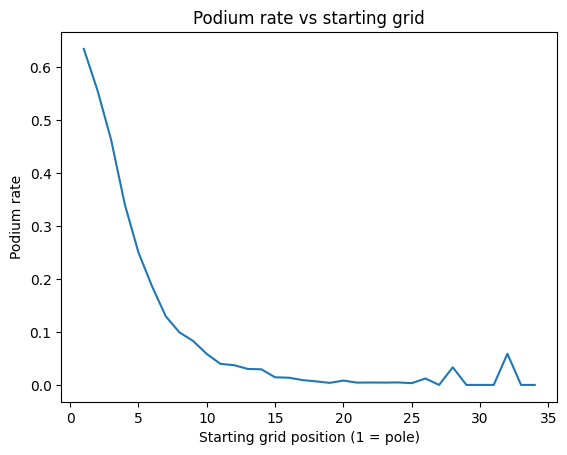

In [8]:
miss = model_df.isna().mean().sort_values(ascending=False)
display(miss.to_frame('missing_rate').head(20))

tmp = Xy[Xy['grid']>=1].copy()
tmp['is_podium'] = (tmp['positionOrder']<=3).astype(int)
grid_podium = tmp.groupby('grid')['is_podium'].mean().reset_index()

plt.figure()
plt.plot(grid_podium['grid'], grid_podium['is_podium'])
plt.xlabel('Starting grid position (1 = pole)')
plt.ylabel('Podium rate')
plt.title('Podium rate vs starting grid')
plt.savefig(FIG_DIR/'podium_rate_vs_grid.png', bbox_inches='tight')
plt.show()


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

year_cut = int(np.quantile(model_df['year'], 0.8))
train = model_df[model_df['year'] <= year_cut]
test  = model_df[model_df['year'] >  year_cut]

X_train = train[features]
y_train = train['podium'].astype(int)
X_test  = test[features]
y_test  = test['podium'].astype(int)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print('ROC-AUC:', round(roc_auc_score(y_test, proba), 3))
print('Accuracy:', round(accuracy_score(y_test, pred), 3))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))


ROC-AUC: 0.918
Accuracy: 0.892
Confusion matrix:
 [[4099  204]
 [ 339  402]]


In [11]:
test_with_pred = test.assign(pred_proba=proba)

def top3_hit_rate(df):
    top3 = df.sort_values('pred_proba', ascending=False).head(3)
    return top3['podium'].sum()/3.0

race_hits = test_with_pred.groupby('raceId').apply(top3_hit_rate)
print('Avg fraction of correct picks among top-3 predictions:', round(race_hits.mean(), 3))


Avg fraction of correct picks among top-3 predictions: 0.615


/tmp/ipython-input-4238371351.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  race_hits = test_with_pred.groupby('raceId').apply(top3_hit_rate)


In [12]:
coefs = pd.Series(clf.coef_[0], index=features).sort_values(ascending=False)
coefs.to_csv('figures/logreg_coefficients.csv')
display(coefs)

findings = [
    "Grid position shows a strong monotonic relationship with podium probability.",
    "Both driver and team recent form (rolling podium rates) provide useful signal.",
    "A simple logistic regression already ranks contenders reasonably well (see top-3 check)."
]
for f in findings: print("-", f)


,0
driver_podium_rate_so_far,2.990027
team_podium_rate_so_far,2.418203
driver_starts_so_far,0.001787
team_starts_so_far,0.000294
year,-0.000918
grid,-0.174401


- Grid position shows a strong monotonic relationship with podium probability.
- Both driver and team recent form (rolling podium rates) provide useful signal.
- A simple logistic regression already ranks contenders reasonably well (see top-3 check).


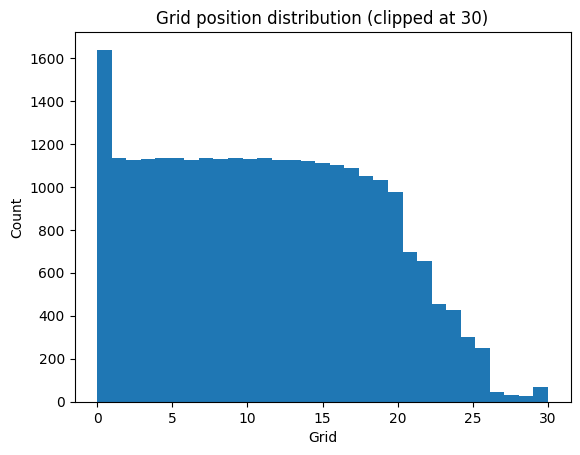

In [13]:
# EDA 1
model_df['grid'].clip(0,30).plot(kind='hist', bins=31, title='Grid position distribution (clipped at 30)')
plt.xlabel('Grid'); plt.ylabel('Count'); plt.savefig('figures/grid_hist.png', bbox_inches='tight'); plt.show()


/tmp/ipython-input-4064924096.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pod_by_exp = tmp.groupby('exp_bin')['podium'].mean().reset_index()


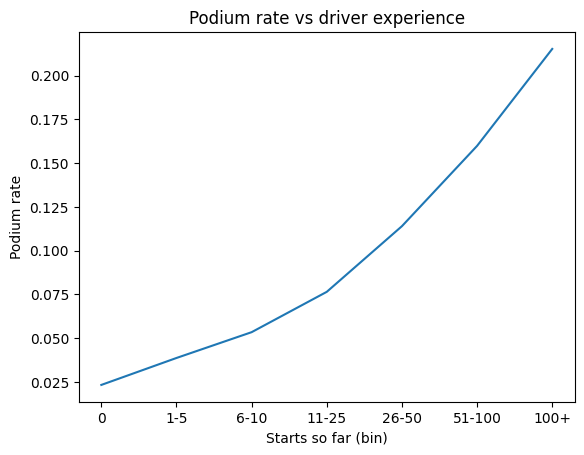

In [14]:
# EDA 2
bins = [-1,0,5,10,25,50,100,1000]
labels = ['0','1-5','6-10','11-25','26-50','51-100','100+']
tmp = model_df.copy()
tmp['exp_bin'] = pd.cut(tmp['driver_starts_so_far'], bins=bins, labels=labels)
pod_by_exp = tmp.groupby('exp_bin')['podium'].mean().reset_index()
plt.figure(); plt.plot(pod_by_exp['exp_bin'], pod_by_exp['podium'])
plt.title('Podium rate vs driver experience'); plt.xlabel('Starts so far (bin)'); plt.ylabel('Podium rate')
plt.savefig('figures/podium_vs_experience.png', bbox_inches='tight'); plt.show()


/tmp/ipython-input-2030969893.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pod_by_team = tmp.groupby('team_rate_bin')['podium'].mean().reset_index()


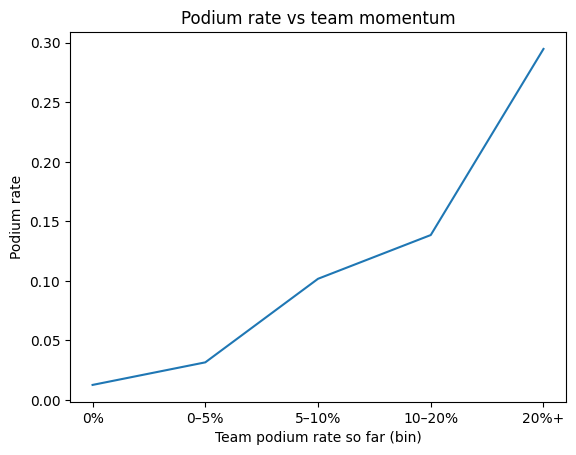

In [15]:
# EDA 3
bins = [-0.01, 0.00, 0.05, 0.10, 0.20, 1.00]
labels = ['0%','0–5%','5–10%','10–20%','20%+']
tmp = model_df.copy()
tmp['team_rate_bin'] = pd.cut(tmp['team_podium_rate_so_far'], bins=bins, labels=labels)
pod_by_team = tmp.groupby('team_rate_bin')['podium'].mean().reset_index()
plt.figure(); plt.plot(pod_by_team['team_rate_bin'], pod_by_team['podium'])
plt.title('Podium rate vs team momentum'); plt.xlabel('Team podium rate so far (bin)'); plt.ylabel('Podium rate')
plt.savefig('figures/podium_vs_team_momentum.png', bbox_inches='tight'); plt.show()
